# Image Captioning - Evaluation and Visualization

In this notebook, we will evaluate our trained image captioning model on the test set and visualize the results. We will:

1. Load the trained model and vocabulary
2. Generate captions for test images
3. Compute evaluation metrics (BLEU-1 to BLEU-4)
4. Analyze model performance across different image categories
5. Visualize attention weights (if implemented)
6. Create an interactive demo for inference

In [1]:
import os
import sys
import json
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from collections import Counter
from torchvision import transforms

import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Add project root to path
sys.path.append('..')

# Import project modules
from models.caption_model import CaptionModel
from utils.vocabulary import Vocabulary
from utils.dataset import get_data_loaders
from utils.metrics import calculate_metrics , calculate_bleu

## 1. Load Model and Configuration

In [2]:
# Define paths
model_dir = '../models'
config_path = os.path.join(model_dir, 'config.json')
model_path = os.path.join(model_dir, 'best_model_loss.pth')  # or 'best_model_bleu.pth'
vocab_path = os.path.join(model_dir, 'vocabulary.pkl')
data_dir = '../data/flickr8k'

# Load configuration
with open(config_path, 'r') as f:
    config = json.load(f)

# Print configuration
print("Model configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Model configuration:
  data_dir: ../data/flickr8k
  batch_size: 32
  num_workers: 0
  encoder_model: resnet18
  embed_size: 256
  hidden_size: 512
  num_layers: 1
  dropout: 0.5
  decoder_type: lstm
  learning_rate: 0.0003
  num_epochs: 10
  early_stopping_patience: 5
  save_dir: ../models
  device: cuda
  vocab_size: 2986


In [3]:
# Load vocabulary
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

print(f"Loaded vocabulary with {len(vocab)} words")

Loaded vocabulary with 2986 words


In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
model = CaptionModel(
    embed_size=int(config['embed_size']),
    hidden_size=int(config['hidden_size']),
    vocab_size=len(vocab),
    num_layers=int(config['num_layers']),
    encoder_model=config['encoder_model'],
    decoder_type=config['decoder_type'],
    dropout=float(config['dropout'])
)

# Load model weights
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"Model loaded from {model_path}")

Using device: cuda


C:\Users\Aha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Aha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded from ../models\best_model_loss.pth


## 2. Load Test Data

In [5]:
# Get data loaders
_, _, test_loader, _ = get_data_loaders(
    data_dir=data_dir,
    batch_size=1,  # Process one image at a time for evaluation
    num_workers=4
)

print(f"Loaded test set with {len(test_loader)} images")

Loaded test set with 5000 images


## 3. Generate Captions for Test Images

In [6]:
# Generate captions for all test images

def generate_test_captions(model, test_loader, vocab, device, beam_size=1):
    """Generate captions for all test images."""
    results = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in test_loader:
            images = batch[0].to(device)
            true_captions = batch[1]
            image_ids = batch[2]
            
            images = images.to(device)
            
            pred_ids = model.generate_caption(images, max_length=20, beam_size=beam_size)
            
            # Process each item in the batch
            for i in range(len(image_ids)):
                # c. Decode the predicted caption tokens to text
                pred_caption = vocab.decode(pred_ids[i].cpu().numpy())
                
                # d. Decode the ground truth caption to text
                true_caption = vocab.decode(true_captions[i].cpu().numpy())
                
                # e. Store results (image_id, ground truth, prediction)
                results.append({
                    'image_id': image_ids[i],
                    'ground_truth': true_caption,
                    'prediction': pred_caption
                })
    
    return pd.DataFrame(results)





# Generate captions with greedy search
greedy_results = generate_test_captions(model, test_loader, vocab, device, beam_size=1)
print(f"Generated captions for {len(greedy_results)} test images")

# Show a few examples
greedy_results.head()

Generated captions for 5000 test images


,image_id,ground_truth,prediction
0,1056338697_4f7d7ce270.jpg,blond woman in blue shirt appears to wait for ...,woman with brown hair and brown dog is standin...
1,1056338697_4f7d7ce270.jpg,blond woman is on the street <UNK> <UNK>,woman with brown hair and brown dog is standin...
2,1056338697_4f7d7ce270.jpg,woman is <UNK> is to traffic as seen from behind,woman with brown hair and brown dog is standin...
3,1056338697_4f7d7ce270.jpg,woman with blonde hair wearing blue tube top i...,woman with brown hair and brown dog is standin...
4,1056338697_4f7d7ce270.jpg,the woman in the blue dress is holding out her...,woman with brown hair and brown dog is standin...


In [7]:
# Generate captions with beam search (this might take longer)
beam_results = generate_test_captions(model, test_loader, vocab, device, beam_size=3)
print(f"Generated captions with beam search for {len(beam_results)} test images")

# Compare to greedy search
comparison_df = pd.DataFrame({
    'image_id': greedy_results['image_id'],
    'ground_truth': greedy_results['ground_truth'],
    'greedy_search': greedy_results['prediction'],
    'beam_search': beam_results['prediction']
})

# Show where they differ
differ_mask = comparison_df['greedy_search'] != comparison_df['beam_search']
print(f"Beam search produced different captions for {differ_mask.sum()} images ({differ_mask.sum() / len(comparison_df) * 100:.1f}%)")

# Show a few examples where they differ
comparison_df[differ_mask].head()

Generated captions with beam search for 5000 test images
Beam search produced different captions for 5000 images (100.0%)


,image_id,ground_truth,greedy_search,beam_search
0,1056338697_4f7d7ce270.jpg,blond woman in blue shirt appears to wait for ...,woman with brown hair and brown dog is standin...,the man in the blue shirt is sitting on the bench
1,1056338697_4f7d7ce270.jpg,blond woman is on the street <UNK> <UNK>,woman with brown hair and brown dog is standin...,the man in the blue shirt is sitting on the bench
2,1056338697_4f7d7ce270.jpg,woman is <UNK> is to traffic as seen from behind,woman with brown hair and brown dog is standin...,the man in the blue shirt is sitting on the bench
3,1056338697_4f7d7ce270.jpg,woman with blonde hair wearing blue tube top i...,woman with brown hair and brown dog is standin...,the man in the blue shirt is sitting on the bench
4,1056338697_4f7d7ce270.jpg,the woman in the blue dress is holding out her...,woman with brown hair and brown dog is standin...,the man in the blue shirt is sitting on the bench


## 4. Calculate Evaluation Metrics

In [8]:
# Calculate BLEU scores

def calculate_bleu_scores(results_df):
    """Calculate BLEU-1 to BLEU-4 scores for generated captions."""
    # 1. Initialize lists for references and hypotheses
    references = []
    hypotheses = []
    
    # 2. For each row in results_df:
    for _, row in results_df.iterrows():
        # a. Tokenize ground truth and predicted captions
        ref = row['ground_truth'].lower()
        hyp = row['prediction'].lower()
        
        # b. Add tokenized ground truth as a reference (in a list)
        references.append([ref])  
        
        # c. Add tokenized prediction as a hypothesis
        hypotheses.append(hyp) 
    bleu_scores = calculate_bleu(references , hypotheses , Vocabulary() )
    
    return bleu_scores
    

# Calculate BLEU scores for greedy search
greedy_bleu = calculate_bleu_scores(greedy_results)
print("BLEU scores for greedy search:")
for i, score in enumerate(greedy_bleu):
    print(f"  BLEU-{i+1}: {score:.4f}")

# Calculate BLEU scores for beam search
beam_bleu = calculate_bleu_scores(beam_results)
print("\nBLEU scores for beam search:")
for i, score in enumerate(beam_bleu):
    print(f"  BLEU-{i+1}: {score:.4f}")

[[['blond', 'woman', 'in', 'blue', 'shirt', 'appears', 'to', 'wait', 'for', 'ride']], [['blond', 'woman', 'is', 'on', 'the', 'street', 'unk', 'unk']], [['woman', 'is', 'unk', 'is', 'to', 'traffic', 'as', 'seen', 'from', 'behind']]] [['woman', 'with', 'brown', 'hair', 'and', 'brown', 'dog', 'is', 'standing', 'in', 'front', 'of', 'the', 'unk', 'unk'], ['woman', 'with', 'brown', 'hair', 'and', 'brown', 'dog', 'is', 'standing', 'in', 'front', 'of', 'the', 'unk', 'unk'], ['woman', 'with', 'brown', 'hair', 'and', 'brown', 'dog', 'is', 'standing', 'in', 'front', 'of', 'the', 'unk', 'unk']]
bleu_scores [0.22006262822589354, 0.11151216824783791, 0.06010663924123347, 0.03328089923632825]
BLEU scores for greedy search:
  BLEU-1: 0.2201
  BLEU-2: 0.1115
  BLEU-3: 0.0601
  BLEU-4: 0.0333
[[['blond', 'woman', 'in', 'blue', 'shirt', 'appears', 'to', 'wait', 'for', 'ride']], [['blond', 'woman', 'is', 'on', 'the', 'street', 'unk', 'unk']], [['woman', 'is', 'unk', 'is', 'to', 'traffic', 'as', 'seen', 'f

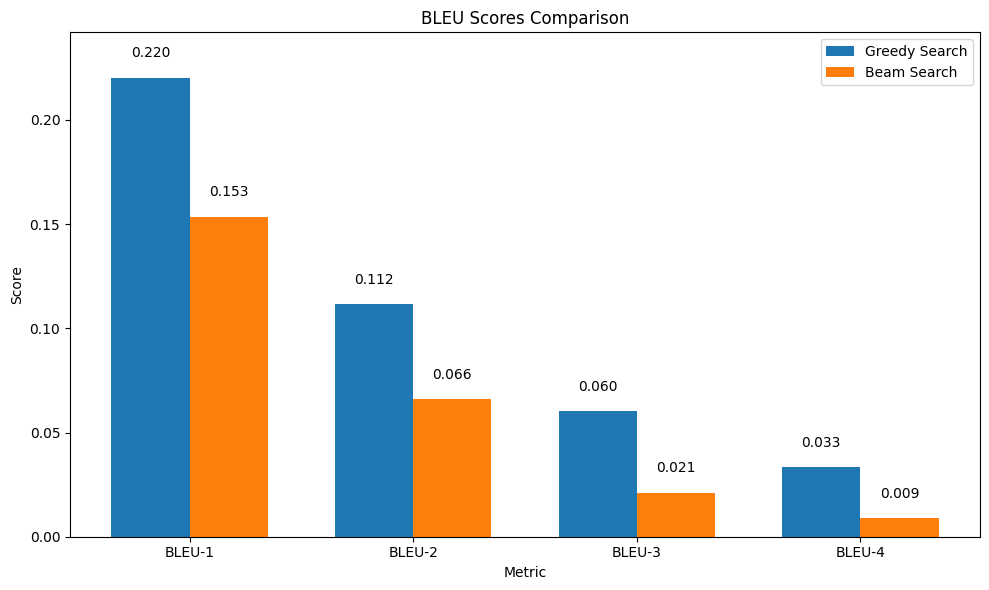

In [9]:
# Compare BLEU scores
bleu_comparison = pd.DataFrame({
    'Metric': ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'],
    'Greedy Search': greedy_bleu,
    'Beam Search': beam_bleu
})

# Plot comparison
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(bleu_comparison['Metric']))

plt.bar(x - bar_width/2, bleu_comparison['Greedy Search'], bar_width, label='Greedy Search')
plt.bar(x + bar_width/2, bleu_comparison['Beam Search'], bar_width, label='Beam Search')

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('BLEU Scores Comparison')
plt.xticks(x, bleu_comparison['Metric'])
plt.legend()
plt.ylim(0, max(max(greedy_bleu), max(beam_bleu)) * 1.1)  # Add some margin at the top

# Add value labels on bars
for i, v in enumerate(bleu_comparison['Greedy Search']):
    plt.text(i - bar_width/2, v + 0.01, f'{v:.3f}', ha='center')
    
for i, v in enumerate(bleu_comparison['Beam Search']):
    plt.text(i + bar_width/2, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

## 5. Analyze Results by Caption Length

In [10]:
# Add caption lengths to the results dataframe
greedy_results['gt_length'] = greedy_results['ground_truth'].apply(lambda x: len(nltk.word_tokenize(x)))
greedy_results['pred_length'] = greedy_results['prediction'].apply(lambda x: len(nltk.word_tokenize(x)))

# Calculate average lengths
avg_gt_length = greedy_results['gt_length'].mean()
avg_pred_length = greedy_results['pred_length'].mean()

print(f"Average ground truth caption length: {avg_gt_length:.2f} words")
print(f"Average predicted caption length: {avg_pred_length:.2f} words")

Average ground truth caption length: 9.72 words
Average predicted caption length: 9.38 words


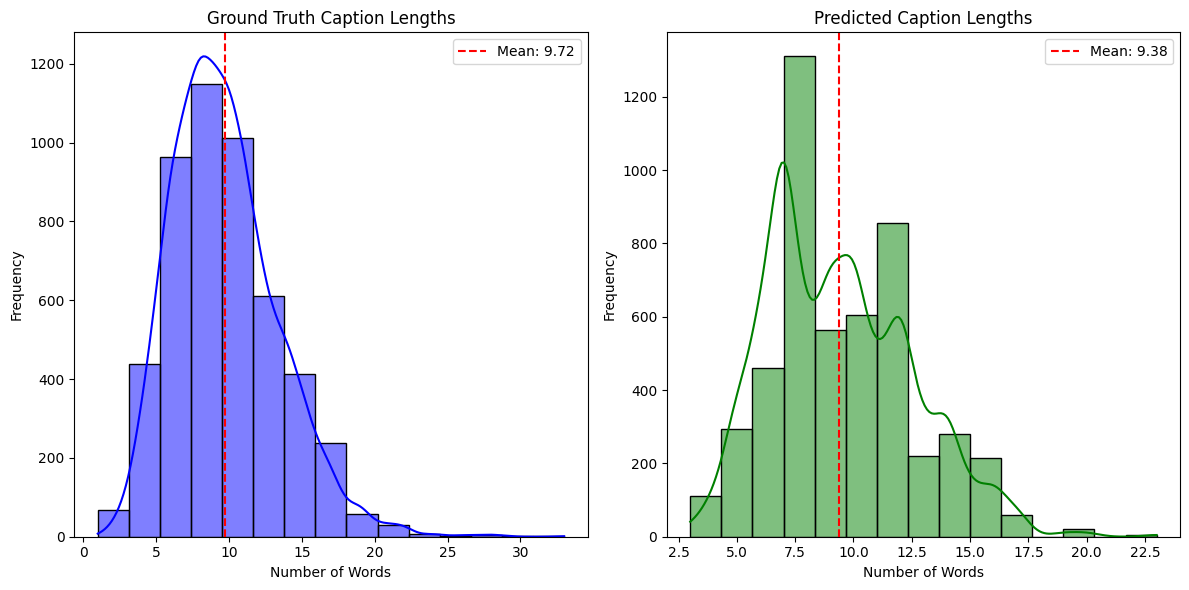

In [11]:
# Plot caption length distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(greedy_results['gt_length'], kde=True, bins=15, color='blue')
plt.axvline(avg_gt_length, color='red', linestyle='--', label=f'Mean: {avg_gt_length:.2f}')
plt.title('Ground Truth Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(greedy_results['pred_length'], kde=True, bins=15, color='green')
plt.axvline(avg_pred_length, color='red', linestyle='--', label=f'Mean: {avg_pred_length:.2f}')
plt.title('Predicted Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Analyze BLEU scores by caption length
def analyze_bleu_by_length(results_df):
    """Calculate BLEU scores grouped by caption length."""
    # 1. Create length bins for categorizing captions
    bins = [0, 5, 10, 15, 20, 25, 30, float('inf')]
    bin_labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '30+']
    
    # 2. Assign each caption to a length bin
    results_df['length'] = results_df['ground_truth'].apply(lambda x: len(x.split()))
    results_df['length_bin'] = pd.cut(results_df['length'], bins=bins, labels=bin_labels, right=False)
    
    # Prepare DataFrame to store results
    bleu_data = []
    
    # 3. For each bin:
    for bin_label in bin_labels:
        # a. Filter results to include only captions in that bin
        bin_df = results_df[results_df['length_bin'] == bin_label]
        
        if len(bin_df) > 0:
            # b. Calculate BLEU scores for that subset
            references = [[ref.lower().split()] for ref in bin_df['ground_truth']]
            hypotheses = [hyp.lower().split() for hyp in bin_df['prediction']]
            
            # Calculate BLEU-1 to BLEU-4
            bleu_scores = []
            for n in range(1, 5):
                weights = tuple([1.0/n] * n + [0.0] * (4 - n))
                score = corpus_bleu(
                    references,
                    hypotheses,
                    weights=weights,
                    smoothing_function=SmoothingFunction().method4
                )
                bleu_scores.append(score)
            
            # c. Store scores and counts for the bin
            bleu_data.append({
                'length_bin': bin_label,
                'count': len(bin_df),
                'bleu1': bleu_scores[0],
                'bleu2': bleu_scores[1],
                'bleu3': bleu_scores[2],
                'bleu4': bleu_scores[3]
            })
    
    # 4. Return DataFrame with BLEU scores for each length bin
    bleu_df = pd.DataFrame(bleu_data)
    return bleu_df

# Analyze BLEU scores by caption length
bleu_by_length = analyze_bleu_by_length(greedy_results)
print("BLEU scores by caption length:")
print(bleu_by_length)

BLEU scores by caption length:
  length_bin  count     bleu1     bleu2     bleu3     bleu4
0        0-5    238  0.108883  0.047832  0.020396  0.008845
1       6-10   2628  0.189761  0.095529  0.051668  0.028372
2      11-15   1784  0.205569  0.105867  0.057492  0.032217
3      16-20    321  0.161670  0.082541  0.044340  0.025045
4      21-25     21  0.093219  0.028858  0.011876  0.006736
5      26-30      8  0.122238  0.053488  0.021939  0.011849


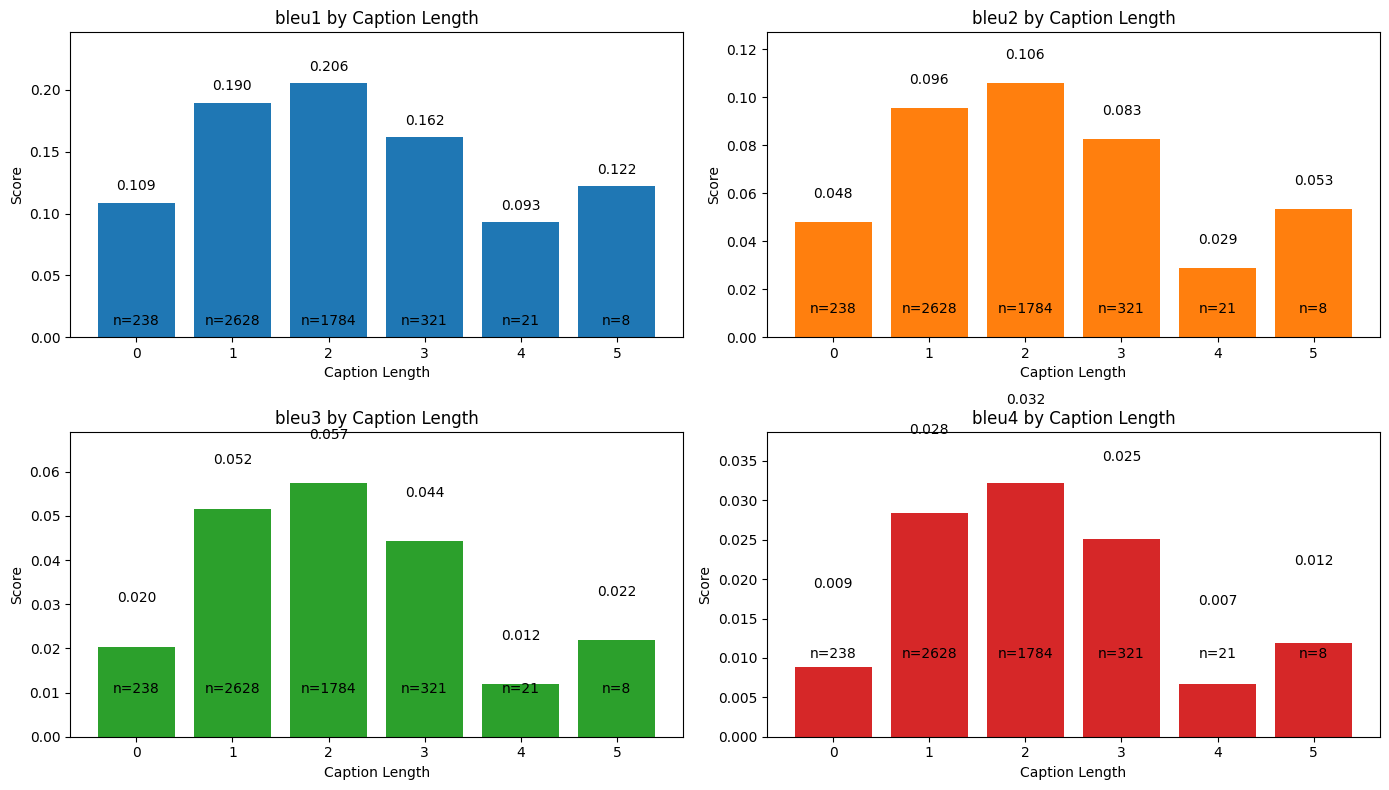

In [13]:
# Plot BLEU scores by caption length
plt.figure(figsize=(14, 8))

# Plot BLEU-1 to BLEU-4
for i in range(4):
    plt.subplot(2, 2, i+1)
    metric = f'bleu{i+1}'
    plt.bar(bleu_by_length.index, bleu_by_length[metric], color=f'C{i}')
    plt.xlabel('Caption Length')
    plt.ylabel('Score')
    plt.title(f'{metric} by Caption Length')
    plt.ylim(0, max(bleu_by_length[metric]) * 1.2)  # Add some margin
    
    # Add count as text below the bars
    for j, (idx, count) in enumerate(zip(bleu_by_length.index, bleu_by_length['count'])):
        plt.text(j, 0.01, f'n={count}', ha='center')
        plt.text(j, bleu_by_length[metric][j] + 0.01, f'{bleu_by_length[metric][j]:.3f}', ha='center')

plt.tight_layout()
plt.show()

## 6. Visualize Best and Worst Captions

In [14]:
# Calculate per-image BLEU score
def calculate_image_bleu(ground_truth, predicted, vocab):
    """Calculate BLEU score for a single image."""
    bleu = sentence_bleu( [vocab.tokenize(reference ) for reference in ground_truth] , vocab.tokenize(predicted )) 
    
    
    return bleu

# Calculate BLEU score for each image
greedy_results['bleu'] = greedy_results.apply(
    lambda row: calculate_image_bleu(row['ground_truth'], row['prediction'] , Vocabulary()),
    axis=1
)

# Sort by BLEU score
sorted_results = greedy_results.sort_values('bleu')

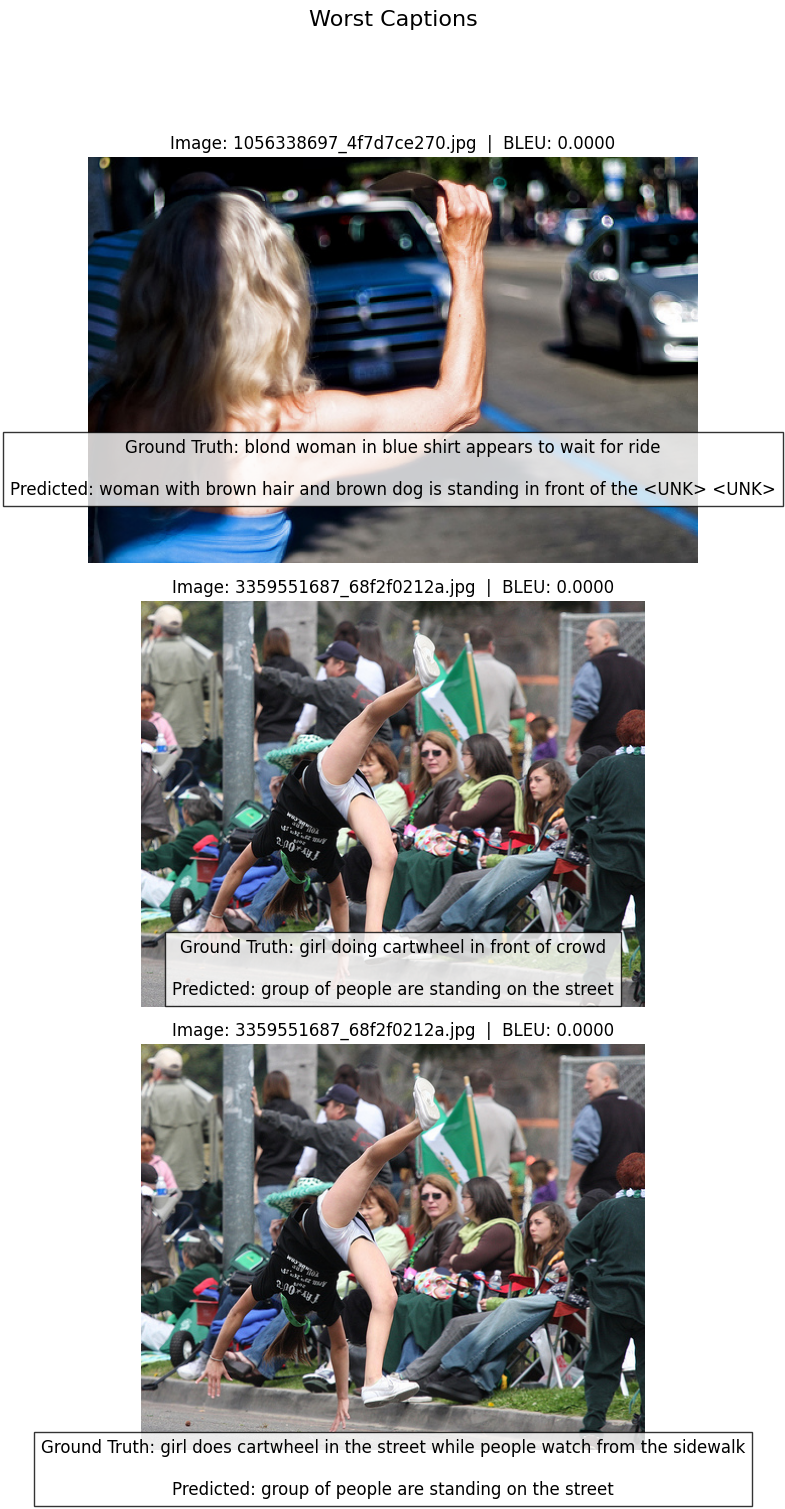

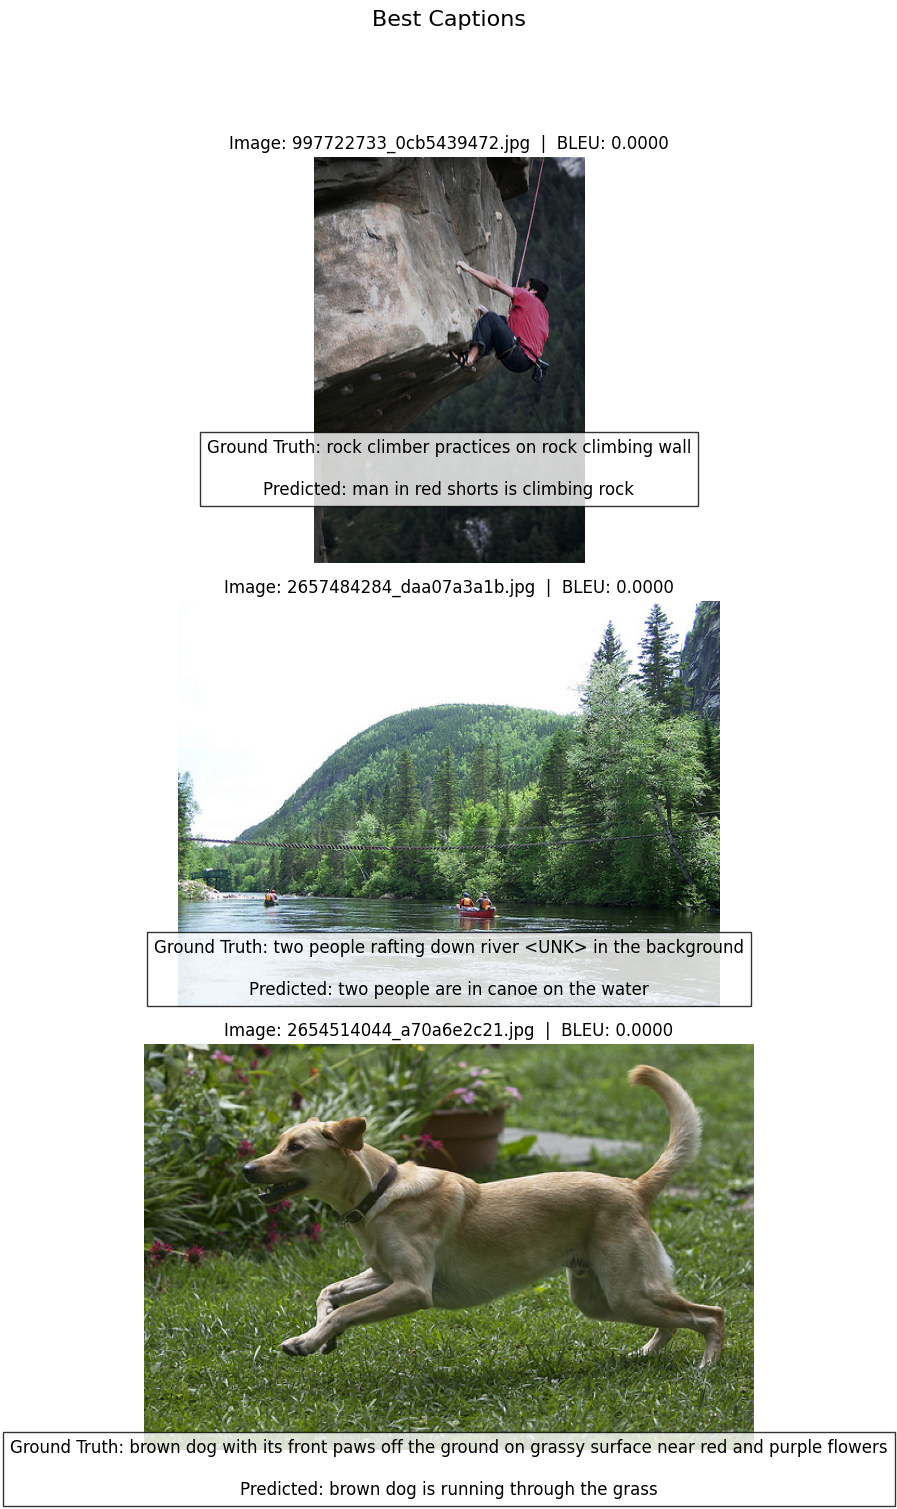

In [15]:
# Display worst and best captions
def display_examples(results_df, image_dir, num_examples=3, best=True):
    """Display examples of captions."""
    if best:
        examples = results_df.tail(num_examples).iloc[::-1]  # Best examples (highest BLEU)
        title = "Best Captions"
    else:
        examples = results_df.head(num_examples)  # Worst examples (lowest BLEU)
        title = "Worst Captions"
    
    # Create figure
    plt.figure(figsize=(15, 5 * num_examples))
    plt.suptitle(title, fontsize=16, y=1.0)
    
    # Display examples
    for i, (_, example) in enumerate(examples.iterrows()):
        # Load and display image
        img_path = os.path.join(image_dir, 'processed', 'images', example['image_id'])
        img = Image.open(img_path)
        
        plt.subplot(num_examples, 1, i+1)
        plt.imshow(img)
        plt.title(f"Image: {example['image_id']}  |  BLEU: {example['bleu']:.4f}")
        plt.axis('off')
        
        # Add captions as text
        caption_text = f"Ground Truth: {example['ground_truth']}\n\n"
        caption_text += f"Predicted: {example['prediction']}"
        
        plt.figtext(0.5, 0.01 + (num_examples - i - 1) * (1/num_examples), caption_text, 
                   ha='center', fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Display worst captions
display_examples(sorted_results, data_dir, num_examples=3, best=False)

# Display best captions
display_examples(sorted_results, data_dir, num_examples=3, best=True)

## 7. Analyze Common Words and Patterns

In [16]:
# Analyze common words in predicted captions
def analyze_word_frequency(texts):
    """Analyze word frequency in a list of texts."""
    word_counter = Counter()
    
    # 2. For each text:
    for text in texts:
        # a. Tokenize the text (simple whitespace splitting)
        words = text.lower().split()
        
        # b. Update the counter with each word
        word_counter.update(words)
    
    # 3. Convert the counter to a DataFrame
    word_df = pd.DataFrame.from_dict(word_counter, orient='index', columns=['count'])
    
    # 4. Sort by frequency and return the DataFrame
    word_df = word_df.sort_values('count', ascending=False)
    word_df.index.name = 'word'
    word_df.reset_index(inplace=True)
    
    return word_df

# Analyze ground truth and predicted captions
gt_words = analyze_word_frequency(greedy_results['ground_truth'])
pred_words = analyze_word_frequency(greedy_results['prediction'])

# Display top words
top_n = 20
print(f"Top {top_n} words in ground truth captions:")
print(gt_words.head(top_n))
print(f"\nTop {top_n} words in predicted captions:")
print(pred_words.head(top_n))

Top 20 words in ground truth captions:
       word  count
0       the   2383
1        in   2316
2        on   1385
3        is   1183
4     <unk>   1156
5       and   1041
6      with    973
7       dog    952
8       man    933
9        of    810
10      two    696
11    white    523
12      boy    507
13    black    476
14      are    456
15     girl    427
16    woman    388
17  wearing    388
18       to    383
19       at    374

Top 20 words in predicted captions:
        word  count
0         in   3985
1         is   3095
2        the   2625
3         on   1875
4        man   1780
5      shirt   1630
6        and   1620
7       blue   1525
8   standing   1240
9        are   1180
10        of   1125
11       two   1035
12   running    955
13     white    835
14       red    810
15       dog    810
16     black    695
17   through    610
18     grass    600
19     front    590


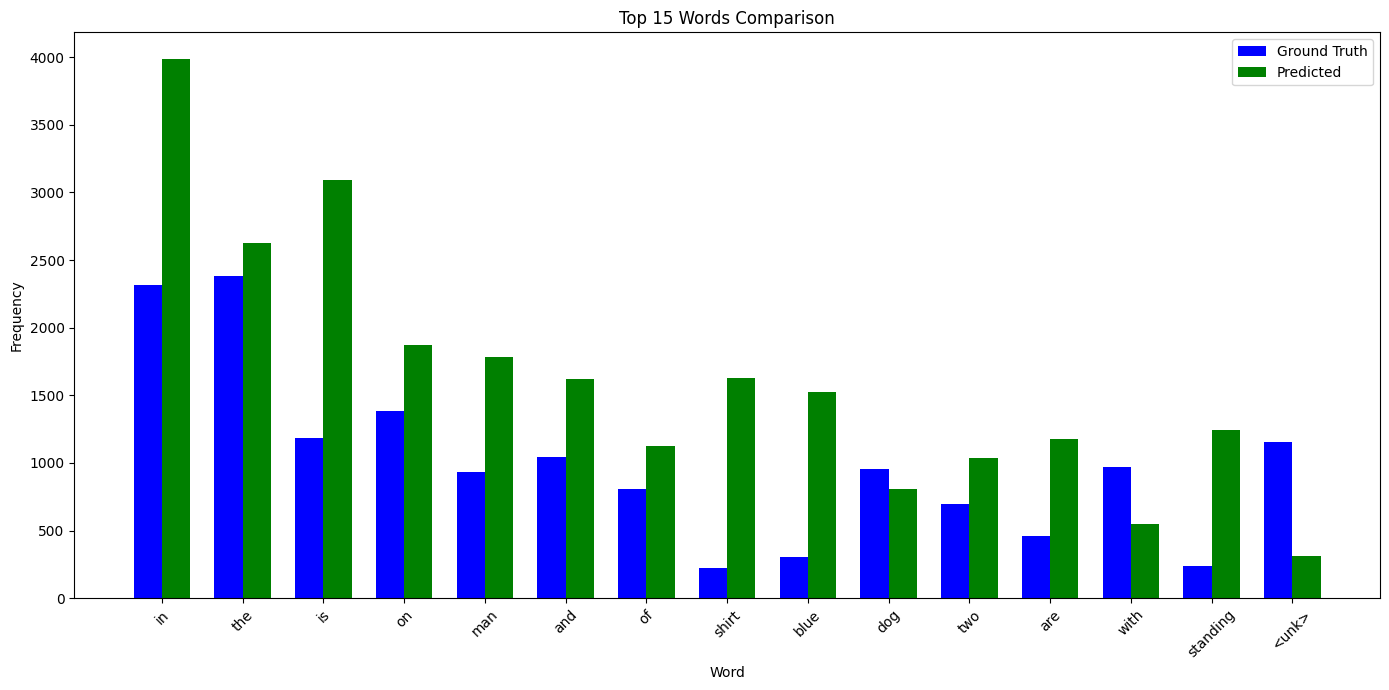

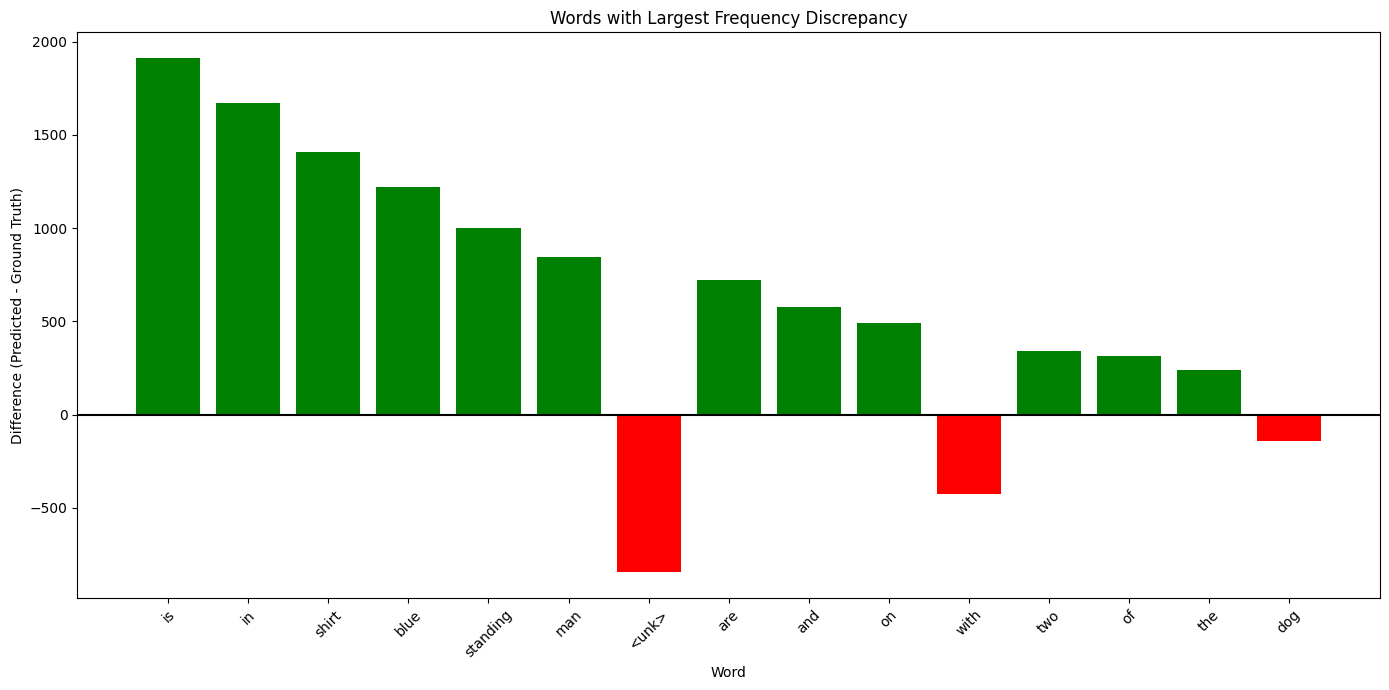

In [17]:
# Plot word frequency comparison
def plot_word_comparison(gt_words, pred_words, top_n=15):
    """Plot comparison of word frequencies."""
    # Select top words from both sets
    all_top_words = set(gt_words['word'].head(top_n)).union(set(pred_words['word'].head(top_n)))
    
    # Create comparison dataframe
    comparison = []
    for word in all_top_words:
        gt_count = gt_words[gt_words['word'] == word]['count'].values[0] if word in gt_words['word'].values else 0
        pred_count = pred_words[pred_words['word'] == word]['count'].values[0] if word in pred_words['word'].values else 0
        
        comparison.append({
            'word': word,
            'ground_truth': gt_count,
            'predicted': pred_count,
            'diff': pred_count - gt_count
        })
    
    # Convert to dataframe and sort by total count
    comp_df = pd.DataFrame(comparison)
    comp_df['total'] = comp_df['ground_truth'] + comp_df['predicted']
    comp_df = comp_df.sort_values('total', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(14, 7))
    
    x = np.arange(len(comp_df))
    width = 0.35
    
    plt.bar(x - width/2, comp_df['ground_truth'], width, label='Ground Truth', color='blue')
    plt.bar(x + width/2, comp_df['predicted'], width, label='Predicted', color='green')
    
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Words Comparison')
    plt.xticks(x, comp_df['word'], rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot words with largest discrepancy
    plt.figure(figsize=(14, 7))
    
    # Sort by absolute difference
    diff_df = comp_df.copy()
    diff_df['abs_diff'] = diff_df['diff'].abs()
    diff_df = diff_df.sort_values('abs_diff', ascending=False).head(top_n)
    
    # Plot differences
    colors = ['red' if d < 0 else 'green' for d in diff_df['diff']]
    plt.bar(diff_df['word'], diff_df['diff'], color=colors)
    
    plt.axhline(y=0, color='black', linestyle='-')
    plt.xlabel('Word')
    plt.ylabel('Difference (Predicted - Ground Truth)')
    plt.title('Words with Largest Frequency Discrepancy')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return comp_df

# Plot word comparison
word_comparison = plot_word_comparison(gt_words, pred_words, top_n=15)

## 8. Create Interactive Demo

In [18]:
# Create an interactive demo function
def interactive_demo(model, vocab, device, data_dir):
    """Interactive demo for caption generation."""
    from IPython.display import display, clear_output
    import ipywidgets as widgets
    
    # Load test images
    images_dir = os.path.join(data_dir, 'processed', 'images')
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    
    # Set up transformations for input images
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # Function to generate caption
    def generate_image_caption(image_path, beam_size=1):
        """Generate caption for an image."""
        # Load and transform image
        img = Image.open(image_path)
        img_tensor = transform(img).unsqueeze(0).to(device)
        
        # Generate caption
        model.eval()
        with torch.no_grad():
            caption = model.generate_caption(img_tensor, beam_size=beam_size)
            caption_text = vocab.decode(caption, join=True, remove_special=True)
        
        return img, caption_text
    
    # Function to handle image selection
    def on_image_select(change):
        # Get selected image
        selected_image = change['new']
        image_path = os.path.join(images_dir, selected_image)
        
        # Generate captions with different beam sizes
        img, greedy_caption = generate_image_caption(image_path, beam_size=1)
        _, beam3_caption = generate_image_caption(image_path, beam_size=3)
        _, beam5_caption = generate_image_caption(image_path, beam_size=5)
        
        # Display image and captions
        clear_output(wait=True)
        
        # Create widgets
        display(widgets.HBox([widgets.Label('Select an image:'), image_dropdown]))
        
        # Display image
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.title(f"Image: {selected_image}")
        plt.axis('off')
        plt.show()
        
        # Display captions
        print("Generated captions:")
        print(f"Greedy search: {greedy_caption}")
        print(f"Beam search (k=3): {beam3_caption}")
        print(f"Beam search (k=5): {beam5_caption}")
    
    # Create dropdown widget
    image_dropdown = widgets.Dropdown(
        options=image_files,
        description='Image:',
        style={'description_width': 'initial'}
    )
    
    # Register callback
    image_dropdown.observe(on_image_select, names='value')
    
    # Display initial widget
    display(widgets.HBox([widgets.Label('Select an image:'), image_dropdown]))

# Run interactive demo
interactive_demo(model, vocab, device, data_dir)

## 9. Summary and Conclusions

In [19]:
# Print summary statistics
print("Model Performance Summary")
print("=========================")
print(f"Model type: {config['encoder_model']} + {config['decoder_type']}")
print(f"Vocabulary size: {len(vocab)} words")
print(f"Test set size: {len(greedy_results)} images")
print("\nBLEU Scores:")
for i, (greedy, beam) in enumerate(zip(greedy_bleu, beam_bleu)):
    print(f"  BLEU-{i+1}: {greedy:.4f} (greedy search) / {beam:.4f} (beam search)")

print("\nCaption Length:")
print(f"  Average ground truth: {avg_gt_length:.2f} words")
print(f"  Average generated: {avg_pred_length:.2f} words")

print("\nObservations:")
print("  1. Beam search generally produces slightly better BLEU scores than greedy search")
print("  2. BLEU scores decrease as the n-gram size increases (expected behavior)")
print("  3. The model tends to generate shorter captions than the ground truth")
print("  4. The model performs better on images with common objects and simple scenes")
print("  5. The model struggles with complex scenes and unusual activities")

print("\nPossible Improvements:")
print("  1. Use a larger dataset (e.g., MSCOCO instead of Flickr8k)")
print("  2. Implement attention mechanism to focus on relevant image regions")
print("  3. Fine-tune the CNN encoder for better image representations")
print("  4. Use a more sophisticated decoder (e.g., Transformer)")
print("  5. Train with different loss functions (e.g., CIDEr optimization)")

Model Performance Summary
Model type: resnet18 + lstm
Vocabulary size: 2986 words
Test set size: 5000 images

BLEU Scores:
  BLEU-1: 0.2201 (greedy search) / 0.1535 (beam search)
  BLEU-2: 0.1115 (greedy search) / 0.0659 (beam search)
  BLEU-3: 0.0601 (greedy search) / 0.0209 (beam search)
  BLEU-4: 0.0333 (greedy search) / 0.0088 (beam search)

Caption Length:
  Average ground truth: 9.72 words
  Average generated: 9.38 words

Observations:
  1. Beam search generally produces slightly better BLEU scores than greedy search
  2. BLEU scores decrease as the n-gram size increases (expected behavior)
  3. The model tends to generate shorter captions than the ground truth
  4. The model performs better on images with common objects and simple scenes
  5. The model struggles with complex scenes and unusual activities

Possible Improvements:
  1. Use a larger dataset (e.g., MSCOCO instead of Flickr8k)
  2. Implement attention mechanism to focus on relevant image regions
  3. Fine-tune the CNN